In [1]:
#Descomprimo el archivo
import zipfile
file_name = "/content/retino.zip"

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('./')  #Extraigo el contenido de la carpeta actual

In [2]:
#Establezco las clases
clases=["DR","No_DR"] #DR: DiabeticRetinopathy, No_DR: No DiabeticRetinopathy

In [3]:
#Cargo la data. Para ello, creo los objetos generadores para cada conjunto de datos
#Sin data augmentation, primero
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1/255, #Reescalo los píxeles de la data
    horizontal_flip=True, #Giro horizontal
    zoom_range=0.2, #Zoom del 20%
    rotation_range=40, #Rotatión de 40°
    fill_mode="nearest", #Acá estoy rellenando el área vacía que quedó de la rotación con los píxeles más "cercanos" a esa área
    width_shift_range=0.2, #Desplazamiento horizontal de la imagen
    brightness_range=[0.5,1.5] #Acá controlo el brillo de la imagen para jugar con la iluminación
)

valid_datagen=ImageDataGenerator(
    rescale=1/255 #Reescalo los píxeles de la data
)

test_datagen=ImageDataGenerator(
    rescale=1/255 #Reescalo los píxeles de la data
)

In [4]:
#Ahora, uso flow_from_directory para cargar la data en batches
train_generator=train_datagen.flow_from_directory(
    directory="/content/retino/train", #Coloco la ruta en donde se encuentra la data de train
    target_size=(224,224),  #Establezco el tamaño de las imágenes
    class_mode="sparse", #Para que las labels sean números enteros
    batch_size=20, #Establezco el número de batches
    color_mode="rgb" #Establezco que sean 3 canales
)

valid_generator=valid_datagen.flow_from_directory(
    directory="/content/retino/valid",
    target_size=(224,224),
    class_mode="sparse",
    batch_size=20,
    color_mode="rgb"
)

test_generator=test_datagen.flow_from_directory(
    directory="/content/retino/test",
    target_size=(224,224),
    class_mode="sparse",
    batch_size=20,
    color_mode="rgb"
)

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


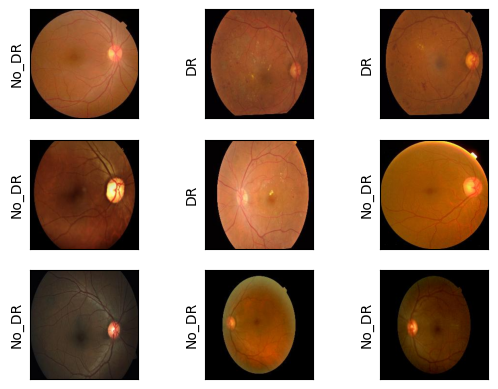

In [5]:
#Plotteo desde la data de test (pues si selecciono las de train, se mostrarán las modificaciones de las transformaciones del data augmentation)
import matplotlib.pyplot as plt

for batch,labels_batch in test_generator:
  for img in range(9):
    plt.subplot(3,3,img+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(batch[img])
    plt.ylabel(clases[int(labels_batch[img])])
  break

In [6]:
#Ahora, uso el modelo preentrenado vgg16 de tensorflow.keras.applications
from tensorflow.keras.applications import vgg16
VGG16=vgg16.VGG16(
    weights="imagenet", #Los pesos del modelo entrenado en el dataset imagenet
    input_shape=(224,224,3), #El input para la data
    include_top=False #Es decir, solamente obtengo la base convolucional
)

In [11]:
#Usaré el modelo preentrenado y realizaré fine-tuning para ver el performance (solamente descongelaré las 2 últimas capas)
#Para ello, inicializo todos los pesos como "trainable"
VGG16.trainable=True

#Ahora, hago "unfreeze" de las últimas 2 capas
for layer in VGG16.layers[:-2]:
  layer.trainable=False #Todas las capas, excepto las 2 últimas, establezco como no trainable

In [12]:
#Veo el sumamry del modelo
VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [13]:
#Ahora, solamente añado capas densas al modelo y ver el performance
from tensorflow import keras
from tensorflow.keras import layers
x=VGG16.output
x=layers.Flatten()(x) #Capa que convierte a vectores 1-d para la capa densa
x=layers.Dense(500,activation="relu")(x) #Estará conectada a una capa de 5000 neuronas
x=layers.Dropout(0.5)(x) #Capa de dropout para evitar el overfitting (aunque se debe elegir el mejor valor)
x=layers.Dense(100,activation="relu")(x)
x=layers.Dropout(0.5)(x)
output=layers.Dense(2,activation="softmax")(x) #Uso softmax ya que se clasificación binaria y quiero obtener la probabilidad de cada clase
modelo=keras.Model(VGG16.inputs,output)

In [14]:
#Summary
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │      12,544,500 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,309,490 (104.18 MB)

 Trainable params: 14,954,610 (57.05 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [15]:
#Ajusto el valor del learning rate del optimizador
from tensorflow.keras.optimizers import Adam
optimizador=Adam(
    learning_rate=0.001 #Este valor debe ajustarse dependiendo del performance durante el training
)

In [16]:
#Compile step
modelo.compile(
    optimizer=optimizador,
    loss="sparse_categorical_crossentropy", #Los labels van a ser o bien 0 o bien 1
    metrics=["accuracy"]
)

In [17]:
#Callbacks que se ejecutarán durante el entrenamiento
from tensorflow.keras import callbacks
ES=callbacks.EarlyStopping(
    monitor="val_loss", #Métrica a monitorear
    patience=5, #Número de épocas luego del mejor valor de la métrica monitoreada, sino se para el entrenamiento
    restore_best_weights=True #El modelo tendrá los pesos de la época en el mejor valor de la métrica monitoreada
)

In [19]:
MC=callbacks.ModelCheckpoint(
    filepath="DR_finetuning_da.keras", #filepath en el que se almacenará el modelo
    monitor="val_loss", #Métrica a monitorear
    save_best_only=True #Que se guarde el modelo en el momento en que se registró el mejor valor para la métrica monitoreada
)

In [20]:
#Entreno el modelo y lo guardo en la variable "history" para realizar las gráficas
history=modelo.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[ES,MC]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 498ms/step - accuracy: 0.7268 - loss: 0.9189 - val_accuracy: 0.9209 - val_loss: 0.2704
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 333ms/step - accuracy: 0.9129 - loss: 0.2880 - val_accuracy: 0.7778 - val_loss: 0.3920
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 327ms/step - accuracy: 0.9181 - loss: 0.2487 - val_accuracy: 0.9266 - val_loss: 0.1990
Epoch 4/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.9309 - loss: 0.2022 - val_accuracy: 0.8908 - val_loss: 0.2759
Epoch 5/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.9088 - loss: 0.2599 - val_accuracy: 0.9247 - val_loss: 0.2327
Epoch 6/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 331ms/step - accuracy: 0.9308 - loss: 0.2239 - val_accuracy: 0.9209 - val_loss: 0.2030
Epoch 7/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 319ms/step - accuracy: 0.9305 - loss: 0.2236 - val_accuracy: 0.9303 - val_loss: 0.1937
Epoch 8/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step - accuracy: 0.9337 - loss: 0.2124 - val

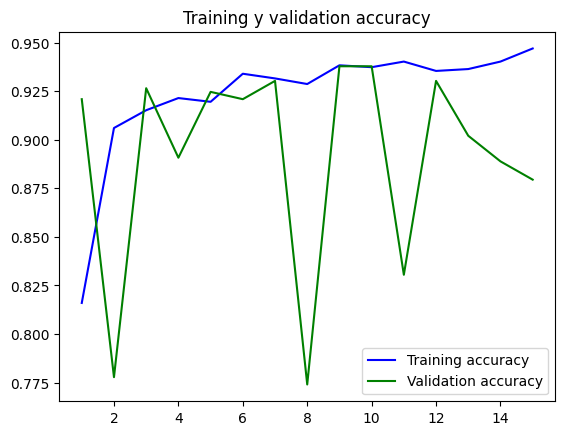

In [21]:
#Hago un plotteo del rendimiento de la red durante el entrenamiento
#Accuracy
accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
epocas=range(1,len(accuracy)+1)
plt.plot(epocas,accuracy,"b",label="Training accuracy")
plt.plot(epocas,val_accuracy,"g",label="Validation accuracy")
plt.title("Training y validation accuracy")
plt.legend()

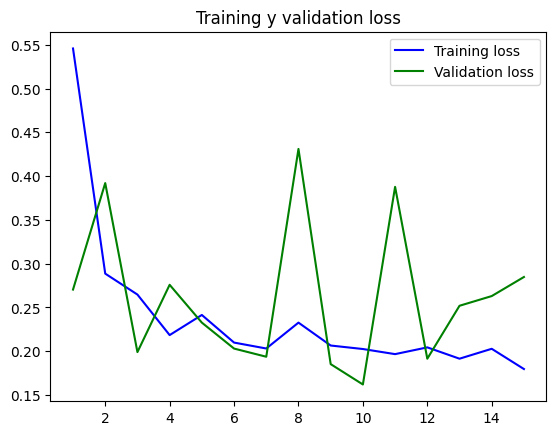

In [22]:
#Loss
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epocas=range(1,len(loss)+1)
plt.plot(epocas,loss,"b",label="Training loss")
plt.plot(epocas,val_loss,"g",label="Validation loss")
plt.title("Training y validation loss")
plt.legend()

In [24]:
#Cargo el modelo guardado y lo pruebo en test
from tensorflow.keras.models import load_model
modelo_no_finetuning=load_model("/content/DR_finetuning_da.keras")
val_loss_m,val_acc_m=modelo_no_finetuning.evaluate(test_generator)
print("Loss:",val_loss_m)
print("Accuracy:",val_acc_m)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9683 - loss: 0.1043
Loss: 0.1198631227016449
Accuracy: 0.9567099809646606
